# **Libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report,precision_score, recall_score

# **Read Data/EDA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Occupancy_Estimation.csv')

In [ ]:
df.head(3)

Date      Time  S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light  \
0  2017/12/22  10:49:41    24.94    24.75    24.56    25.38       121   
1  2017/12/22  10:50:12    24.94    24.75    24.56    25.44       121   
2  2017/12/22  10:50:42    25.00    24.75    24.50    25.44       121   

   S2_Light  S3_Light  S4_Light  S1_Sound  S2_Sound  S3_Sound  S4_Sound  \
0        34        53        40      0.08      0.19      0.06      0.06   
1        33        53        40      0.93      0.05      0.06      0.06   
2        34        53        40      0.43      0.11      0.08      0.06   

   S5_CO2  S5_CO2_Slope  S6_PIR  S7_PIR  Room_Occupancy_Count  
0     390      0.769231       0       0                     1  
1     390      0.646154       0       0                     1  
2     390      0.519231       0       0                     1

In [ ]:
df.dtypes

Date                     object
Time                     object
S1_Temp                 float64
S2_Temp                 float64
S3_Temp                 float64
S4_Temp                 float64
S1_Light                  int64
S2_Light                  int64
S3_Light                  int64
S4_Light                  int64
S1_Sound                float64
S2_Sound                float64
S3_Sound                float64
S4_Sound                float64
S5_CO2                    int64
S5_CO2_Slope            float64
S6_PIR                    int64
S7_PIR                    int64
Room_Occupancy_Count      int64
dtype: object

In [ ]:
df.shape

(10129, 19)

In [ ]:
df.isnull().sum()

Date                    0
Time                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64

<ipython-input-8-424079eb2fc9>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sn.heatmap(df.corr(), cmap="Greens", annot=True)


<function matplotlib.pyplot.show(close=None, block=None)>

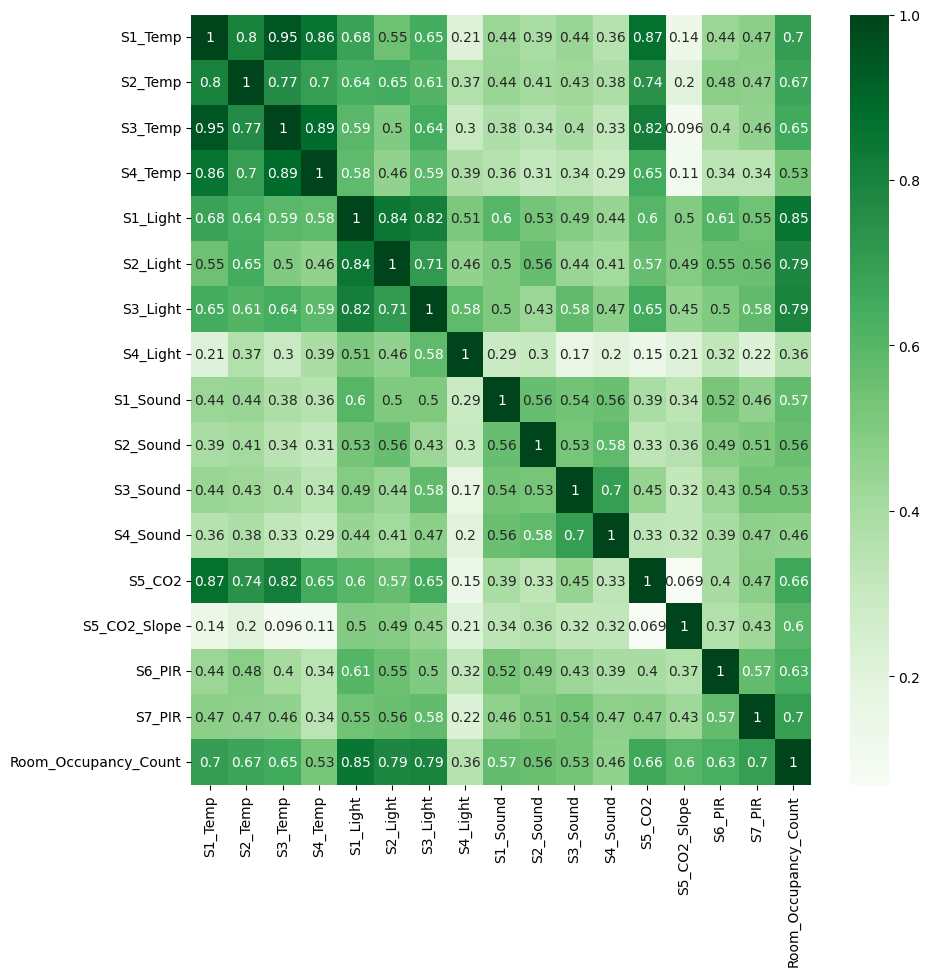

In [ ]:
plt.figure(figsize=(10,10))
heatmap = sn.heatmap(df.corr(), cmap="Greens", annot=True)
plt. show
#S1&S3 Correlation is 95?

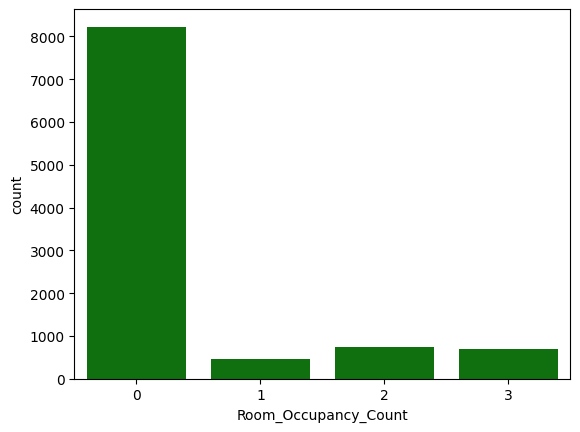

In [ ]:
sn.countplot(x="Room_Occupancy_Count", color='green',data=df)
plt.show()
#imbalance

In [ ]:
df['Time'].head()

0    10:49:41
1    10:50:12
2    10:50:42
3    10:51:13
4    10:51:44
Name: Time, dtype: object

In [ ]:
df['Time']=pd.to_datetime(df['Time'])
df['hour']=df['Time'].dt.hour
df[['Time','hour']].head(3)

Time  hour
0 2024-01-26 10:49:41    10
1 2024-01-26 10:50:12    10
2 2024-01-26 10:50:42    10

In [ ]:
value = df.loc[130, ['Time', 'hour']]
print(value)

Time    2024-01-26 11:58:37
hour                     11
Name: 130, dtype: object


<ipython-input-13-b2c746ea147d>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Occupancy_through_hours = df.groupby('hour').mean().reset_index()


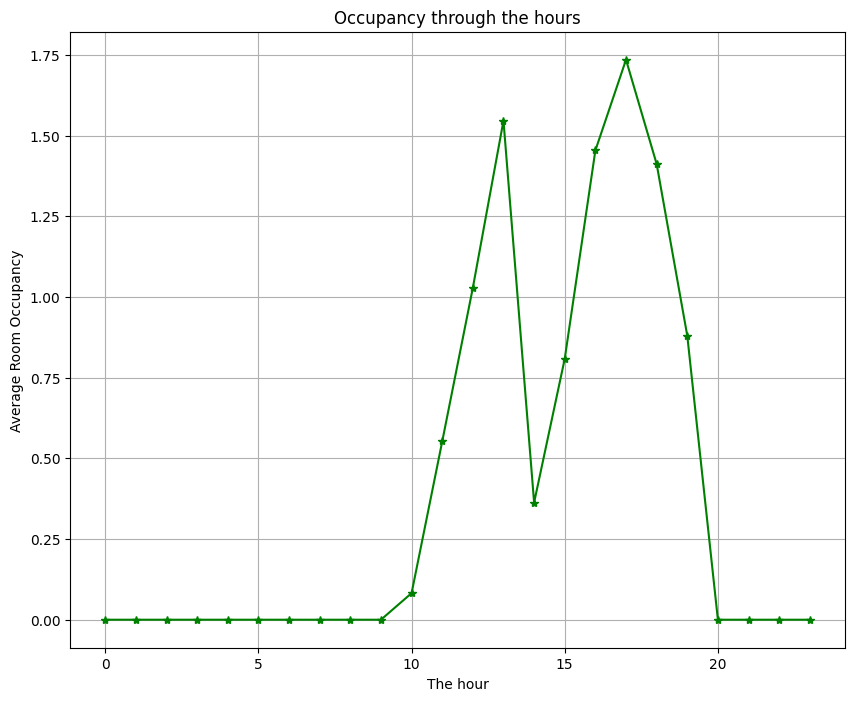

In [ ]:
Occupancy_through_hours = df.groupby('hour').mean().reset_index()
plt.figure(figsize=(10,8))
plt.plot(Occupancy_through_hours['hour'], Occupancy_through_hours['Room_Occupancy_Count'], marker='*',color='green')
plt.title('Occupancy through the hours')
plt.xlabel('The hour')
plt.ylabel('Average Room Occupancy')
plt.grid(True)
plt.show()
# Peak occupancy hour is 17 = 5:00 PM
# low occupancy hours are between 0 to 9 AM and 8 PM to 12:00 PM
# overall trend of occupancy throughout the day

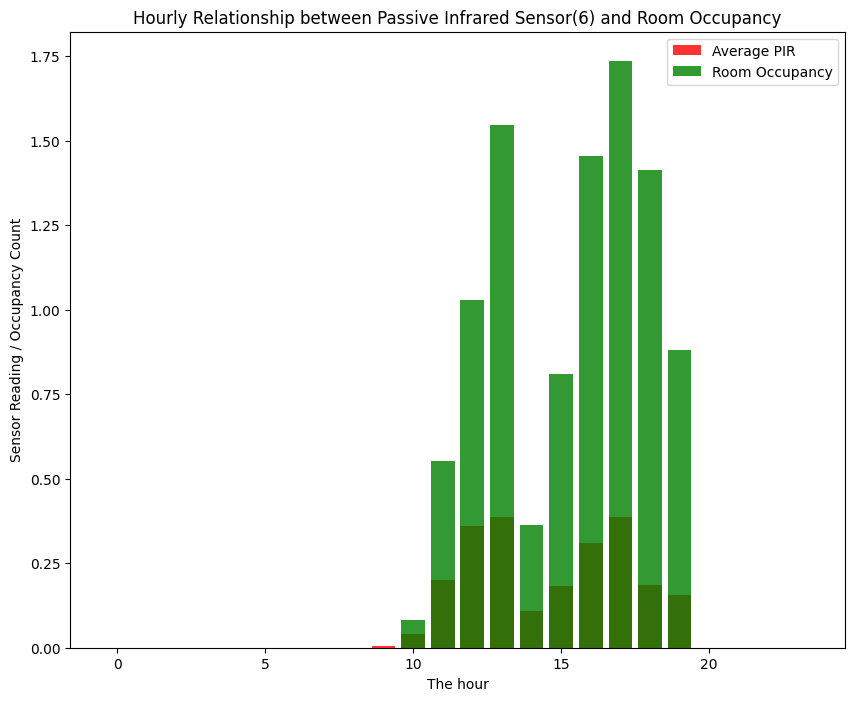

In [ ]:
# to observe if the PIR can affect room occupancy throughout the day
#which hour of the day have both the PIR and room occupancy are high
# at the hour 5:00 PM the average room occupancy is high when there is PIR(detect motion)
# high correlation indicates PIR sensor is effective in detecting occupancy.
plt.figure(figsize=(10,8))
plt.bar(Occupancy_through_hours['hour'], Occupancy_through_hours['S6_PIR'], color='r', alpha=0.8, label='Average PIR')
plt.bar(Occupancy_through_hours['hour'], Occupancy_through_hours['Room_Occupancy_Count'], color='g', alpha=0.8,label='Room Occupancy')
plt.xlabel('The hour')
plt.ylabel('Sensor Reading / Occupancy Count')
plt.title('Hourly Relationship between Passive Infrared Sensor(6) and Room Occupancy')
plt.legend()
plt.show()

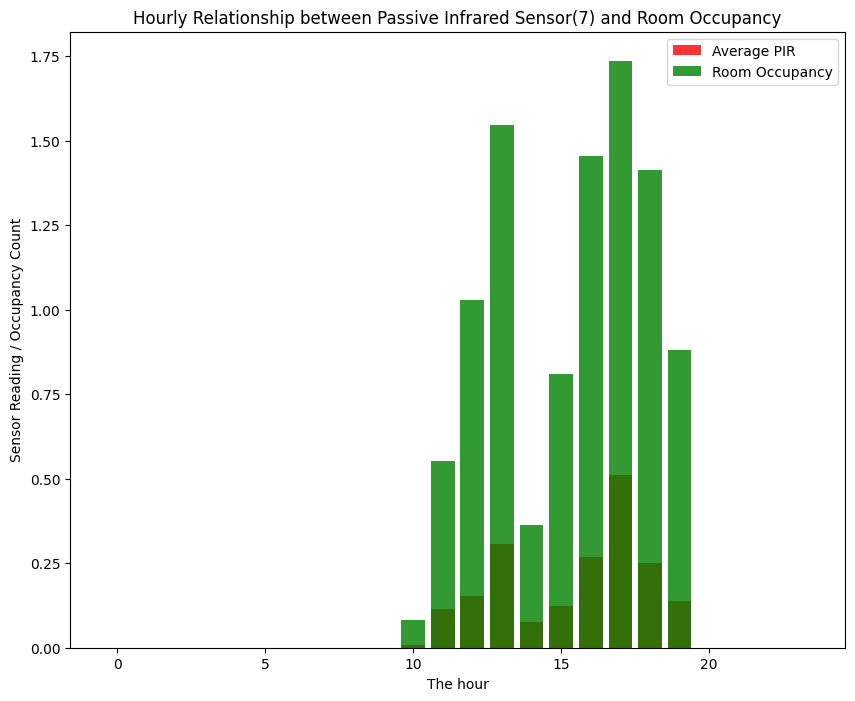

In [ ]:
plt.figure(figsize=(10,8))
plt.bar(Occupancy_through_hours['hour'], Occupancy_through_hours['S7_PIR'], color='r', alpha=0.8, label='Average PIR')
plt.bar(Occupancy_through_hours['hour'], Occupancy_through_hours['Room_Occupancy_Count'], color='g', alpha=0.8,label='Room Occupancy')
plt.xlabel('The hour')
plt.ylabel('Sensor Reading / Occupancy Count')
plt.title('Hourly Relationship between Passive Infrared Sensor(7) and Room Occupancy')
plt.legend()
plt.show()

<ipython-input-16-d58c8a8b72af>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True,color='green')


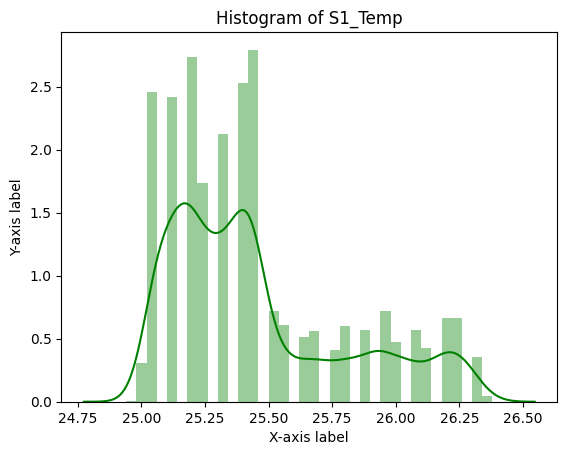

Number of outliers BEFORE: 0


<ipython-input-16-d58c8a8b72af>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True,color='green')


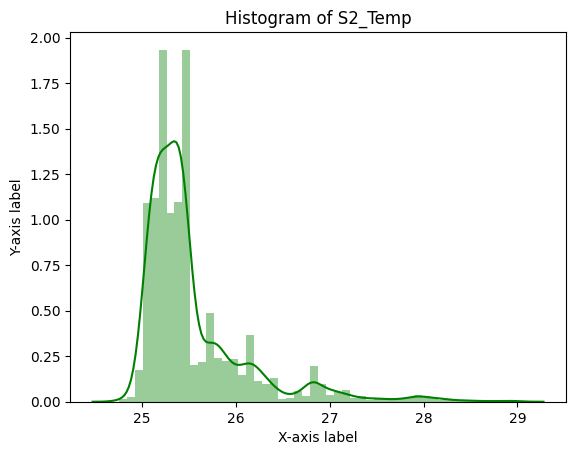

Number of outliers BEFORE: 241


<ipython-input-16-d58c8a8b72af>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True,color='green')


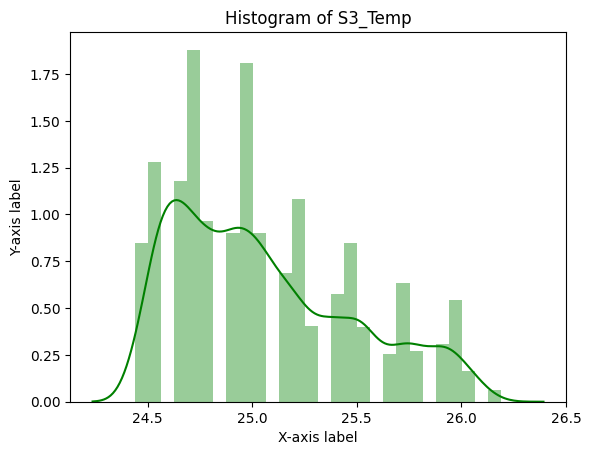

Number of outliers BEFORE: 0


<ipython-input-16-d58c8a8b72af>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True,color='green')


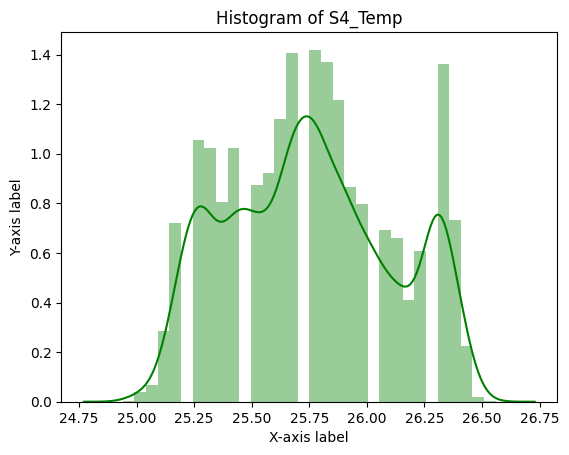

Number of outliers BEFORE: 0


<ipython-input-16-d58c8a8b72af>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True,color='green')


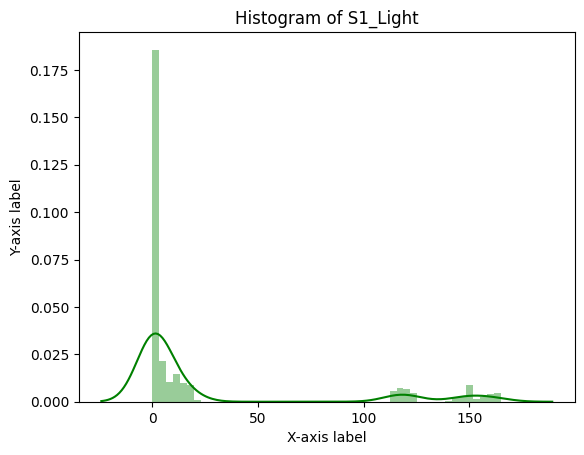

Number of outliers BEFORE: 0


<ipython-input-16-d58c8a8b72af>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True,color='green')


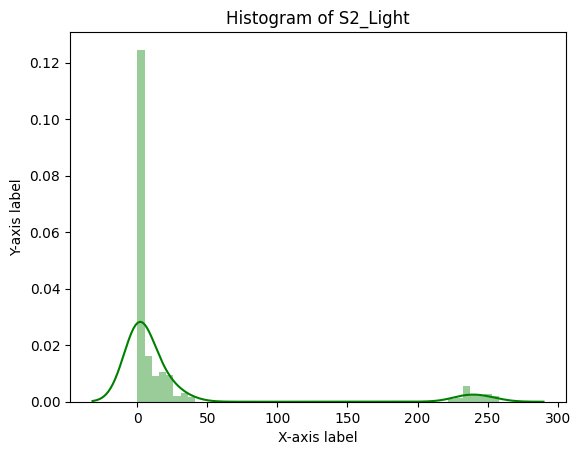

Number of outliers BEFORE: 837


<ipython-input-16-d58c8a8b72af>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True,color='green')


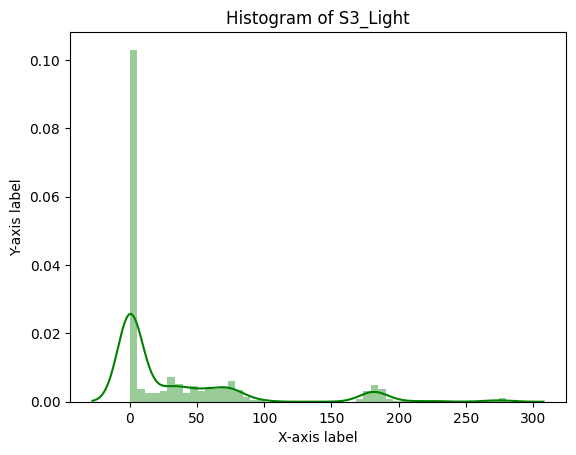

Number of outliers BEFORE: 155


<ipython-input-16-d58c8a8b72af>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True,color='green')


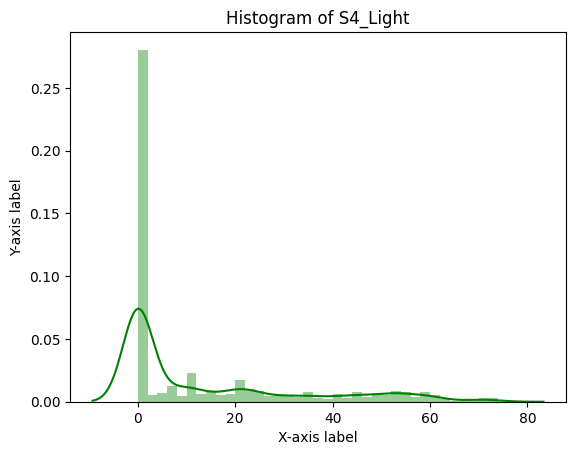

Number of outliers BEFORE: 29


<ipython-input-16-d58c8a8b72af>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True,color='green')


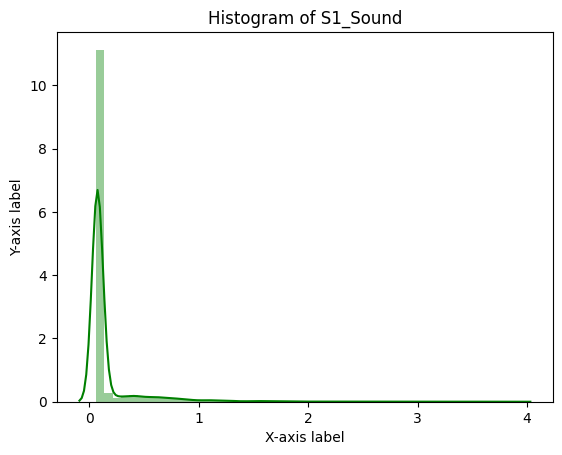

Number of outliers BEFORE: 229


<ipython-input-16-d58c8a8b72af>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True,color='green')


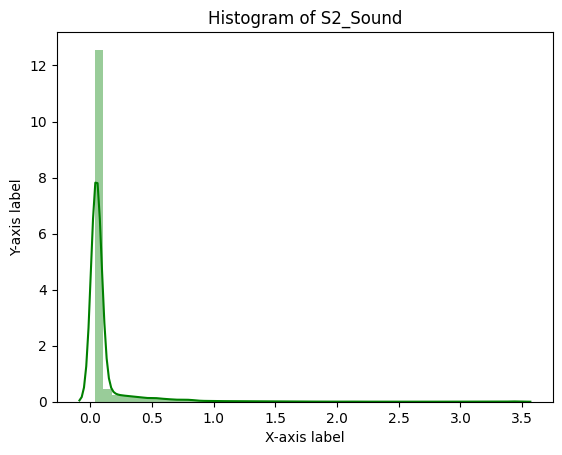

Number of outliers BEFORE: 187


<ipython-input-16-d58c8a8b72af>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True,color='green')


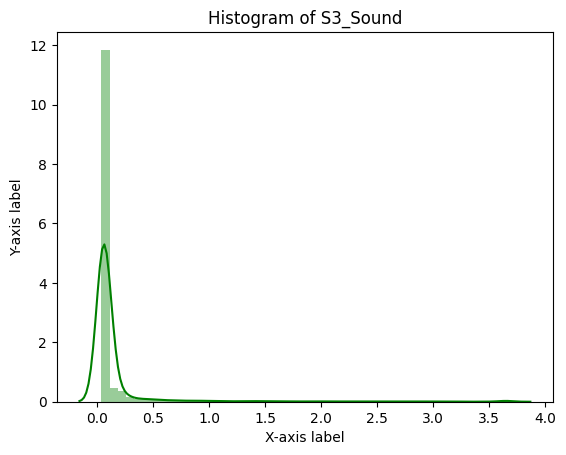

Number of outliers BEFORE: 246


<ipython-input-16-d58c8a8b72af>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True,color='green')


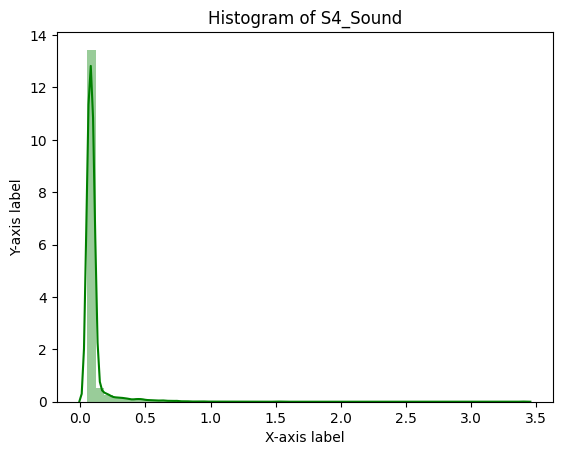

Number of outliers BEFORE: 201


<ipython-input-16-d58c8a8b72af>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True,color='green')


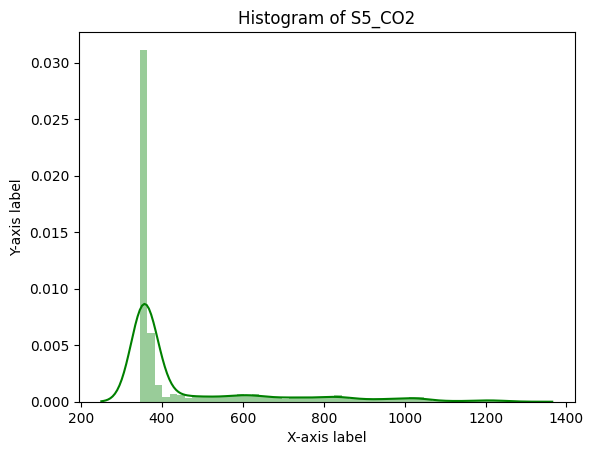

Number of outliers BEFORE: 176


<ipython-input-16-d58c8a8b72af>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True,color='green')


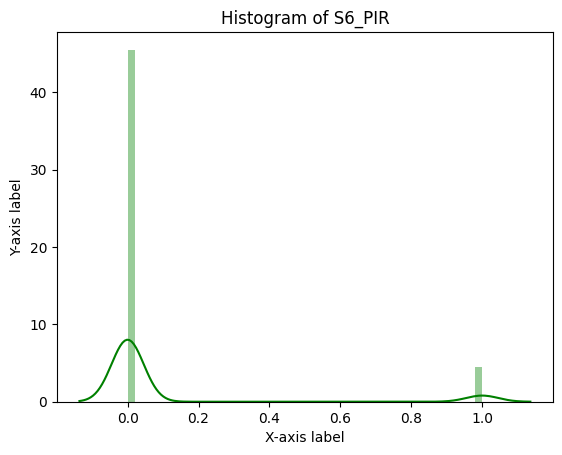

Number of outliers BEFORE: 913


<ipython-input-16-d58c8a8b72af>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde=True,color='green')


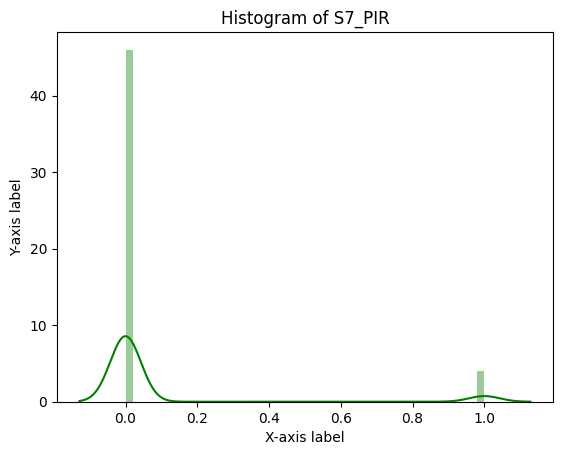

Number of outliers BEFORE: 806


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_outliers(df, col):
    mean = df[col].mean()
    std = df[col].std()
    df['z_score'] = (df[col] - mean) / std
    df['outlier_zscore'] = df['z_score'] > 3
    outliers_zscore = df[df['outlier_zscore'] == True]
    return outliers_zscore

def outlier(df, col):
    outliers_zscore = calculate_outliers(df, col)
    number_of_outliers_zscore = len(outliers_zscore)

    # Plotting the histogram
    sns.distplot(df[col], kde=True,color='green')
    plt.xlabel('X-axis label')
    plt.ylabel('Y-axis label')
    plt.title('Histogram of ' + col)
    plt.show()

    return number_of_outliers_zscore

print("Number of outliers BEFORE:", outlier(df, 'S1_Temp'))
print("Number of outliers BEFORE:", outlier(df, 'S2_Temp'))
print("Number of outliers BEFORE:", outlier(df, 'S3_Temp'))
print("Number of outliers BEFORE:", outlier(df, 'S4_Temp'))

print("Number of outliers BEFORE:", outlier(df, 'S1_Light'))
print("Number of outliers BEFORE:", outlier(df, 'S2_Light'))
print("Number of outliers BEFORE:", outlier(df, 'S3_Light'))
print("Number of outliers BEFORE:", outlier(df, 'S4_Light'))

print("Number of outliers BEFORE:", outlier(df, 'S1_Sound'))
print("Number of outliers BEFORE:", outlier(df, 'S2_Sound'))
print("Number of outliers BEFORE:", outlier(df, 'S3_Sound'))
print("Number of outliers BEFORE:", outlier(df, 'S4_Sound'))

print("Number of outliers BEFORE:", outlier(df, 'S5_CO2'))

print("Number of outliers BEFORE:", outlier(df, 'S6_PIR'))
print("Number of outliers BEFORE:", outlier(df, 'S7_PIR'))

<function matplotlib.pyplot.show(close=None, block=None)>

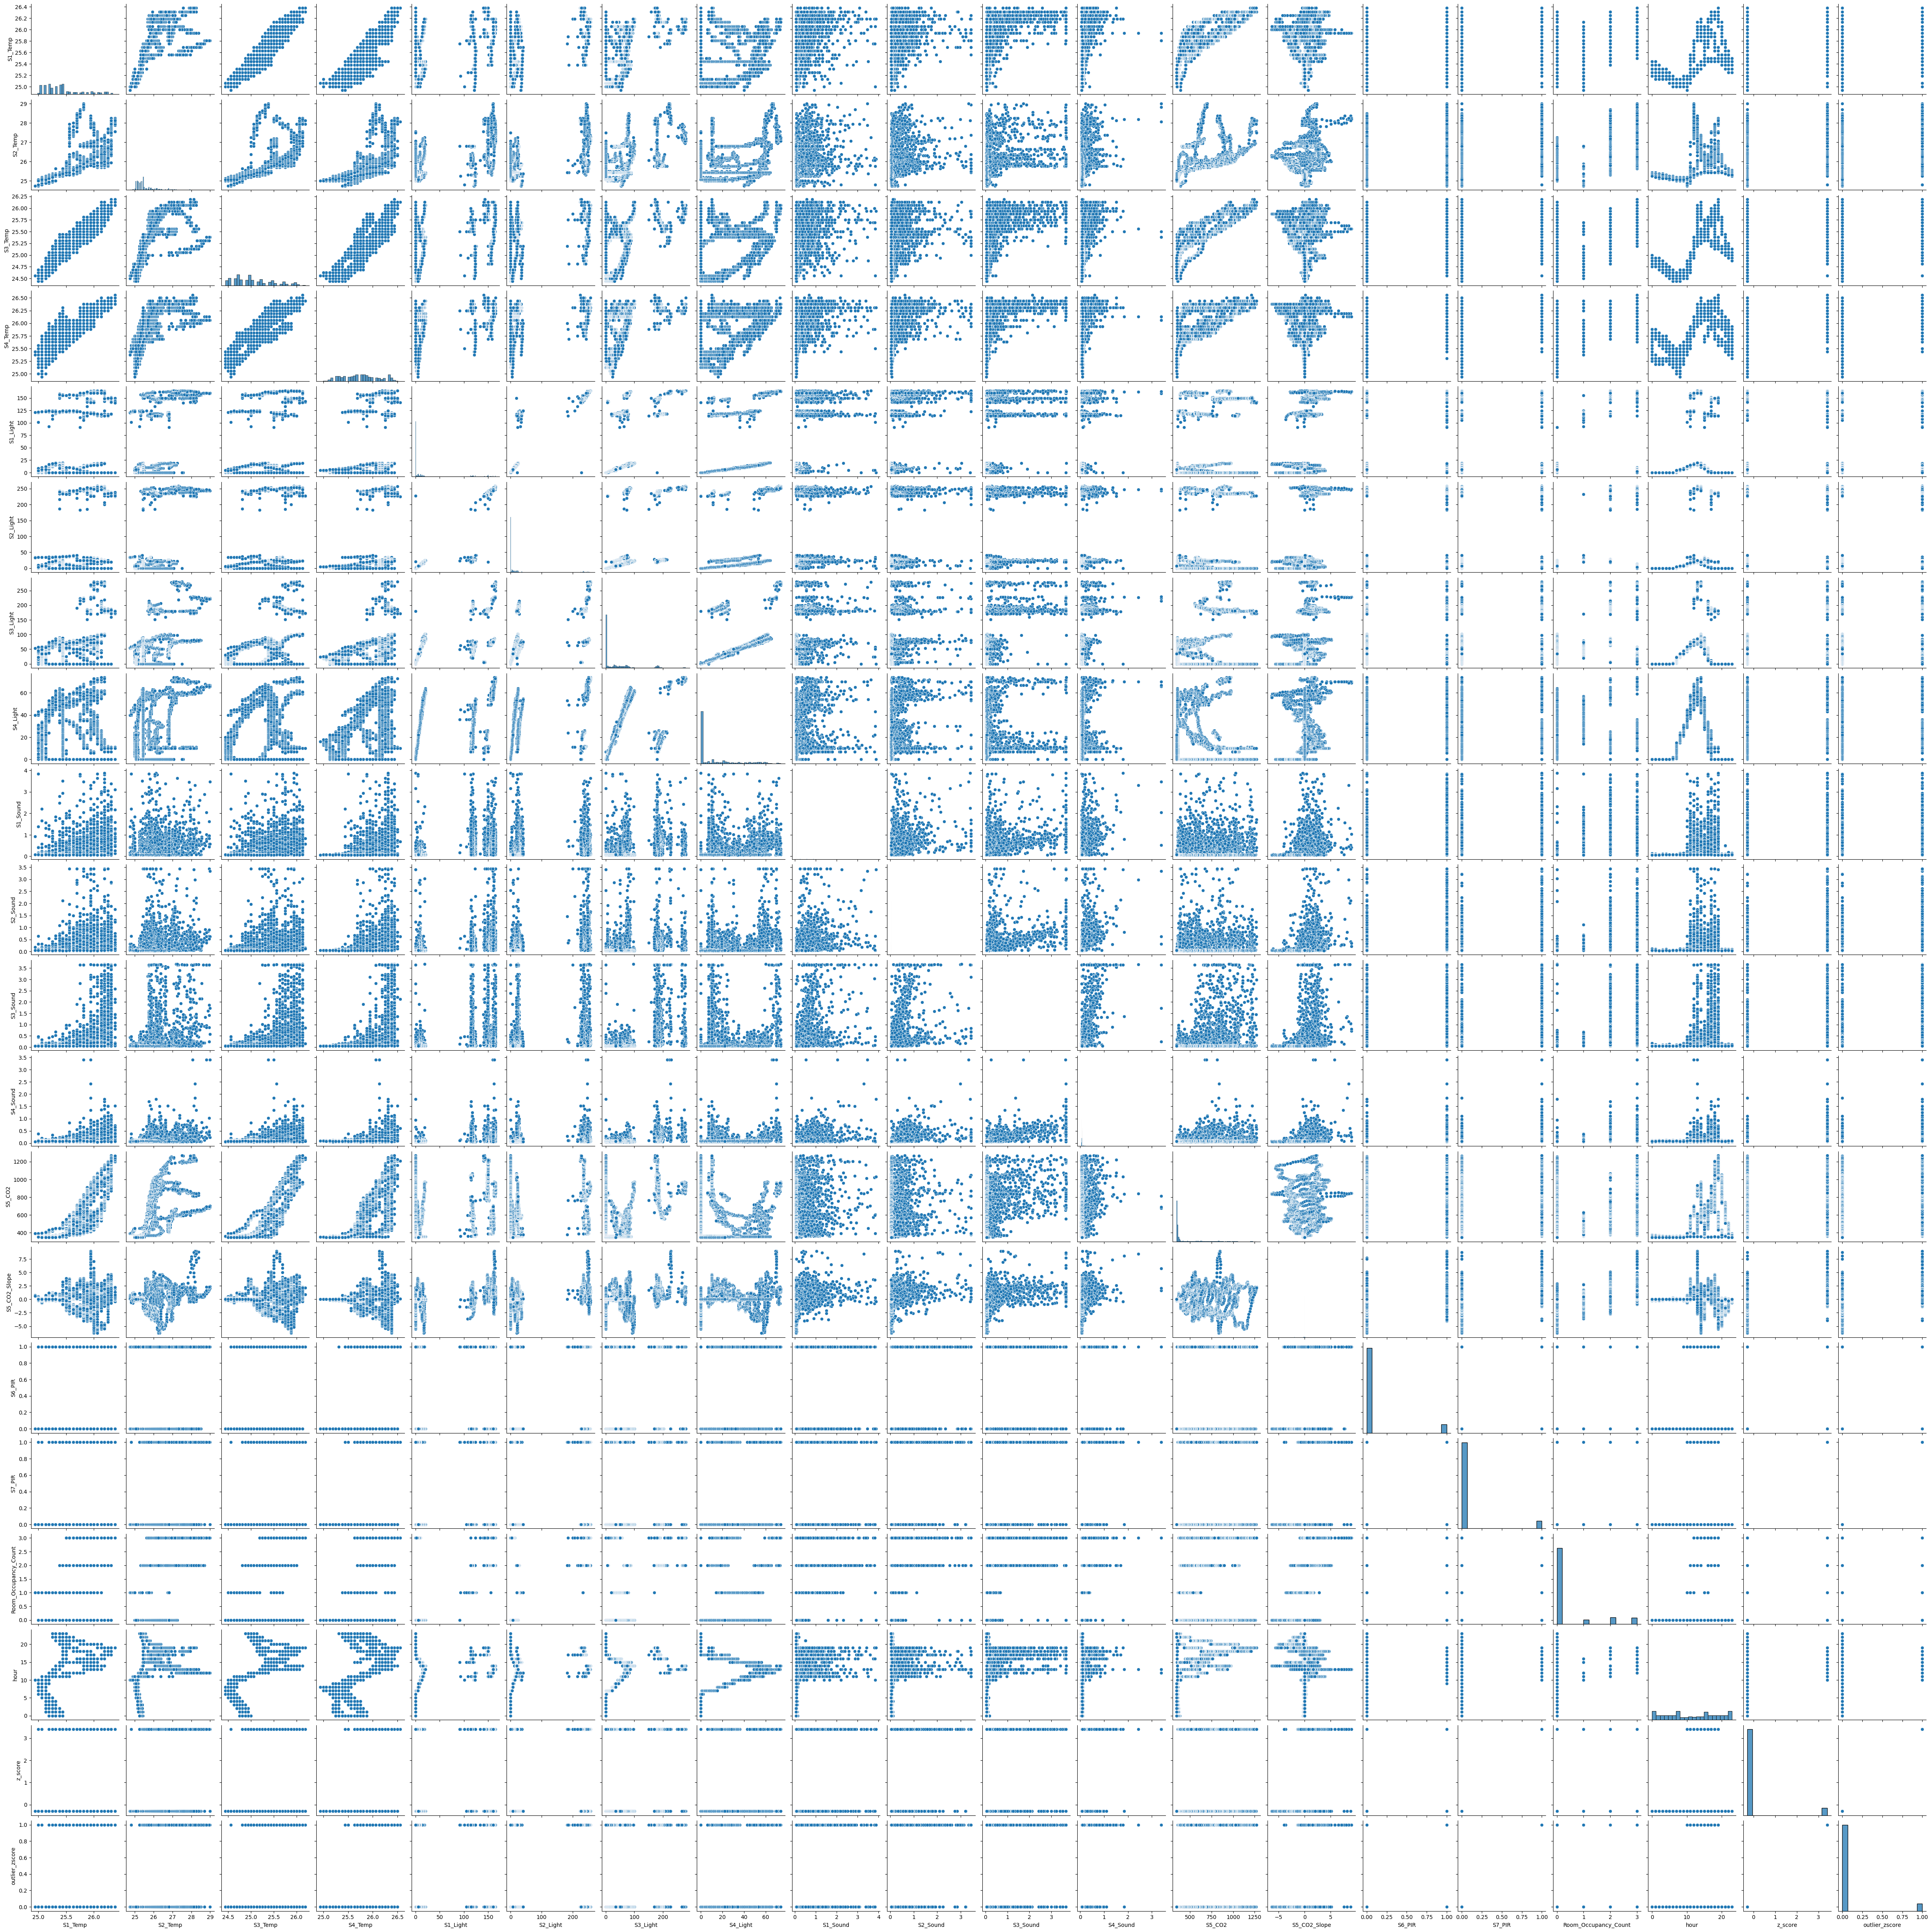

In [ ]:
#sn.pairplot(df)
#plt.show
#the reasn behind plotting this pair plot is to see if the data is linearly seprable
#and that will help me in conducting the SVM to know if i should use the kernel function,
#and the insight i have conducted that i will use this function to help me with non-linear seprable data

# **Data Preprocessing**

In [ ]:
df.columns

Index(['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR',
       'Room_Occupancy_Count', 'hour', 'z_score', 'outlier_zscore'],
      dtype='object')

In [ ]:
df=df.drop(['hour','Date', 'Time','outlier_zscore','z_score'],axis=1)

In [ ]:
columns=['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope']
df[columns]=StandardScaler().fit_transform(df[columns])

# **Methods**

In [ ]:
df.columns

Index(['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light',
       'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
       'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Room_Occupancy_Count'],
      dtype='object')

In [ ]:
X = df.drop('Room_Occupancy_Count',axis=1)
y = df['Room_Occupancy_Count']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### **Random Forest**

**Normal**

In [ ]:
RF=RandomForestClassifier(class_weight='balanced')

In [ ]:
RF.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced')

In [ ]:
predictions = RF.predict(X_test)

In [ ]:
Accuracy_RF_Normal = accuracy_score(y_test, predictions)
Precision_RF_Normal = precision_score(y_test, predictions,average='weighted')
Recall_RF_Normal = recall_score(y_test, predictions,average='weighted')
F1_RF_Normal = f1_score(y_test, predictions,average='weighted')

print('Accuracy: ',Accuracy_RF_Normal)
print('Precision: ',Precision_RF_Normal)
print('Recall: ',Recall_RF_Normal)
print('F1: ',F1_RF_Normal)

Accuracy:  0.9976966107272129
Precision:  0.9976935144172815
Recall:  0.9976966107272129
F1:  0.9976931358345019


**Using Grid Search**

In [ ]:
RF=RandomForestClassifier()

In [ ]:
param_grid = {'max_depth': [10,15,20],'n_estimators':[100,300],'criterion':['gini', 'entropy'],'class_weight': [ {0: 1, 1:3, 2:2, 3:2}, {0: 1,1:4, 2:3, 3:3},{0: 1, 1:7, 2:4, 3:5}]}
grid_search = GridSearchCV(RF, param_grid, cv=7)
grid_search.fit(X_train,y_train)
best_depth = grid_search.best_params_['max_depth']
best_n_estimator = grid_search.best_params_['n_estimators']
best_criterion = grid_search.best_params_['criterion']
best_class_weight = grid_search.best_params_['class_weight']

print(best_depth)
print(best_n_estimator)
print(best_criterion)
print(best_class_weight)

15
100
entropy
{0: 1, 1: 4, 2: 3, 3: 3}


In [ ]:
predictions = grid_search.predict(X_test)

In [ ]:
Accuracy_RF_Grid_search = accuracy_score(y_test, predictions)
Precision_RF_Grid_search = precision_score(y_test, predictions,average='weighted')
Recall_RF_Grid_search = recall_score(y_test, predictions,average='weighted')
F1_RF_Grid_search = f1_score(y_test, predictions,average='weighted')

print('Accuracy: ',Accuracy_RF_Grid_search)
print('Precision: ',Precision_RF_Grid_search)
print('Recall: ',Recall_RF_Grid_search)
print('F1: ',F1_RF_Grid_search)

Accuracy:  0.9983547219480092
Precision:  0.9983543451059322
Recall:  0.9983547219480092
F1:  0.9983526011936127


### **Gradient Boosting**

In [ ]:
df.columns

Index(['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light',
       'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
       'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Room_Occupancy_Count'],
      dtype='object')

**Normal**

In [ ]:
class_weights = compute_sample_weight('balanced', y=y_train)

In [ ]:
GBoost=GradientBoostingClassifier()

In [ ]:
GBoost.fit(X_train,y_train,sample_weight=class_weights)

GradientBoostingClassifier()

In [ ]:
predictions = GBoost.predict(X_test)

In [ ]:
Accuracy_GB_Normal = accuracy_score(y_test, predictions)
Precision_GB_Normal = precision_score(y_test, predictions,average='weighted')
Recall_GB_Normal = recall_score(y_test, predictions,average='weighted')
F1_GB_Normal = f1_score(y_test, predictions,average='weighted')

print('Accuracy: ',Accuracy_GB_Normal)
print('Precision: ',Precision_GB_Normal)
print('Recall: ',Recall_GB_Normal)
print('F1: ',F1_GB_Normal)

Accuracy:  0.9970384995064165
Precision:  0.9970270051173645
Recall:  0.9970384995064165
F1:  0.9970300729362279


**Using Grid Search**

In [ ]:
class_weights = compute_sample_weight('balanced', y=y_train)

In [ ]:
GBoost=GradientBoostingClassifier()

In [ ]:
param_grid = {'max_depth': [10,15,20],'n_estimators':[100,300],'criterion':['friedman_mse', 'squared_error'],'learning_rate':[0.1,0.3]}
grid_search = GridSearchCV(GBoost, param_grid, cv=7)
grid_search.fit(X_train,y_train,sample_weight=class_weights)
best_depth = grid_search.best_params_['max_depth']
best_n_estimator = grid_search.best_params_['n_estimators']
best_criterion = grid_search.best_params_['criterion']
best_learning_rate = grid_search.best_params_['learning_rate']

print(best_depth)
print(best_n_estimator)
print(best_criterion)
print(best_learning_rate)
print(best_class_weight)

10
300
friedman_mse
0.1
{0: 1, 1: 4, 2: 3, 3: 3}


In [ ]:
predictions = grid_search.predict(X_test)

In [ ]:
Accuracy_GB_Grid_search = accuracy_score(y_test, predictions)
Precision_GB_Grid_search = precision_score(y_test, predictions,average='weighted')
Recall_GB_Grid_search = recall_score(y_test, predictions,average='weighted')
F1_GB_Grid_search = f1_score(y_test, predictions,average='weighted')

print('Accuracy: ',Accuracy_GB_Grid_search)
print('Precision: ',Precision_GB_Grid_search)
print('Recall: ',Recall_GB_Grid_search)
print('F1: ',F1_GB_Grid_search)

Accuracy:  0.9960513326752222
Precision:  0.996039635378537
Recall:  0.9960513326752222
F1:  0.9960391070076302


### **Extreme Gradient Boosting**

In [ ]:
df.columns

Index(['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light',
       'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
       'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Room_Occupancy_Count'],
      dtype='object')

**Normal**

In [ ]:
class_weights = compute_sample_weight('balanced', y=y_train)

In [ ]:
XGBoost=xgb.XGBClassifier()

In [ ]:
XGBoost.fit(X_train,y_train,sample_weight=class_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
predictions = XGBoost.predict(X_test)

In [ ]:
Accuracy_XGB_Normal = accuracy_score(y_test, predictions)
Precision_XGB_Normal = precision_score(y_test, predictions,average='weighted')
Recall_XGB_Normal = recall_score(y_test, predictions,average='weighted')
F1_XGB_Normal = f1_score(y_test, predictions,average='weighted')

print('Accuracy: ',Accuracy_XGB_Normal)
print('Precision: ',Precision_XGB_Normal)
print('Recall: ',Recall_XGB_Normal)
print('F1: ',F1_XGB_Normal)

Accuracy:  0.9976966107272129
Precision:  0.9977080182023756
Recall:  0.9976966107272129
F1:  0.9976970872032095


**Using Grid Search**

In [ ]:
class_weights = compute_sample_weight('balanced', y=y_train)

In [ ]:
XGBoost=xgb.XGBClassifier()

In [ ]:
param_grid = {'max_depth': [10,15,20],'n_estimators':[100,300],'learning_rate':[0.1,0.3],'reg_lambda':[0.1, 1.0]}
grid_search = GridSearchCV(XGBoost, param_grid, cv=7)
grid_search.fit(X_train,y_train,sample_weight=class_weights)
best_depth = grid_search.best_params_['max_depth']
best_n_estimator = grid_search.best_params_['n_estimators']
best_learning_rate = grid_search.best_params_['learning_rate']
best_reg_lambda = grid_search.best_params_['reg_lambda']

print(best_depth)
print(best_n_estimator)
print(best_learning_rate)
print(best_reg_lambda)

10
100
0.1
0.1


In [ ]:
predictions = grid_search.predict(X_test)

In [ ]:
Accuracy_XGB_Grid_search = accuracy_score(y_test, predictions)
Precision_XGB_Grid_search = precision_score(y_test, predictions,average='weighted')
Recall_XGB_Grid_search = recall_score(y_test, predictions,average='weighted')
F1_XGB_Grid_search = f1_score(y_test, predictions,average='weighted')

print('Accuracy: ',Accuracy_XGB_Grid_search)
print('Precision: ',Precision_XGB_Grid_search)
print('Recall: ',Recall_XGB_Grid_search)
print('F1: ',F1_XGB_Grid_search)

Accuracy:  0.9970384995064165
Precision:  0.997074576037994
Recall:  0.9970384995064165
F1:  0.9970440895339489


### **Support Vector Machines**

**Normal**

In [ ]:
SVM = SVC(class_weight='balanced')

In [ ]:
SVM.fit(X_train, y_train)

SVC(class_weight='balanced')

In [ ]:
predictions = SVM.predict(X_test)

In [ ]:
Accuracy_SVM_Normal = accuracy_score(y_test, predictions)
Precision_SVM_Normal = precision_score(y_test, predictions,average='weighted')
Recall_SVM_Normal = recall_score(y_test, predictions,average='weighted')
F1_SVM_Normal = f1_score(y_test, predictions,average='weighted')

print('Accuracy: ',Accuracy_SVM_Normal)
print('Precision: ',Precision_SVM_Normal)
print('Recall: ',Recall_SVM_Normal)
print('F1: ',F1_SVM_Normal)

Accuracy:  0.9930898321816387
Precision:  0.9931684764321935
Recall:  0.9930898321816387
F1:  0.9931234788998831


**Using Grid Search**

In [ ]:
SVM = SVC()

In [ ]:
param_grid = {'kernel':['poly', 'rbf'],'C':[1,10,100],'class_weight': [ {0: 1, 1:3, 2:2, 3:2}, {0: 1,1:4, 2:3, 3:3},{0: 1, 1:7, 2:4, 3:5}]}
grid_search = GridSearchCV(SVM, param_grid, cv=7)
grid_search.fit(X_train,y_train)
best_kernel = grid_search.best_params_['kernel']
best_C = grid_search.best_params_['C']
best_class_weight = grid_search.best_params_['class_weight']

print(best_depth)
print(best_C)
print(best_class_weight)

10
1
{0: 1, 1: 3, 2: 2, 3: 2}


In [ ]:
predictions = grid_search.predict(X_test)

In [ ]:
Accuracy_SVM_Grid_search = accuracy_score(y_test, predictions)
Precision_SVM_Grid_search = precision_score(y_test, predictions,average='weighted')
Recall_SVM_Grid_search = recall_score(y_test, predictions,average='weighted')
F1_SVM_Grid_search = f1_score(y_test, predictions,average='weighted')

print('Accuracy: ',Accuracy_SVM_Grid_search)
print('Precision: ',Precision_SVM_Grid_search)
print('Recall: ',Recall_SVM_Grid_search)
print('F1: ',F1_SVM_Grid_search)

Accuracy:  0.9934188877920369
Precision:  0.9934731860762973
Recall:  0.9934188877920369
F1:  0.9934418034409179


# **Results**

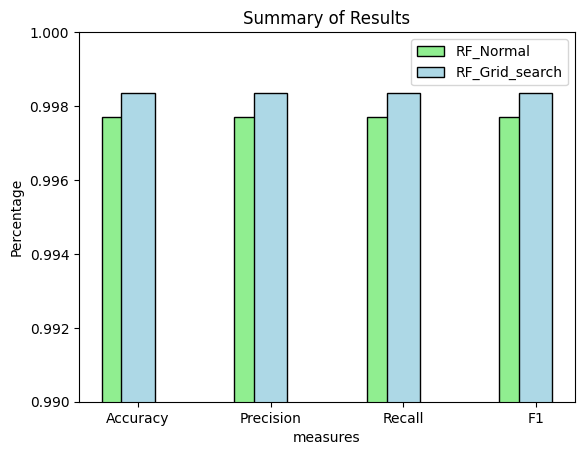

In [ ]:
measures = ['Accuracy','Precision','Recall','F1']

RF_Normal=[Accuracy_RF_Normal,Precision_RF_Normal,Recall_RF_Normal,F1_RF_Normal]
RF_Grid_search=[Accuracy_RF_Grid_search,Precision_RF_Grid_search,Recall_RF_Grid_search,F1_RF_Grid_search]

X_axis = np.arange(len(measures ))


plt.bar(X_axis + 0.1, RF_Normal, color ='lightgreen',width = 0.25,edgecolor = 'black',label = 'RF_Normal')
plt.bar(X_axis + 0.25, RF_Grid_search, color ='lightblue',width = 0.25,edgecolor = 'black',label = 'RF_Grid_search')
plt.xticks(X_axis+0.25, measures)

plt.ylim(0.99, 1)
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("measures")
plt.ylabel("Percentage")
plt.title("Summary of Results")
plt.show()

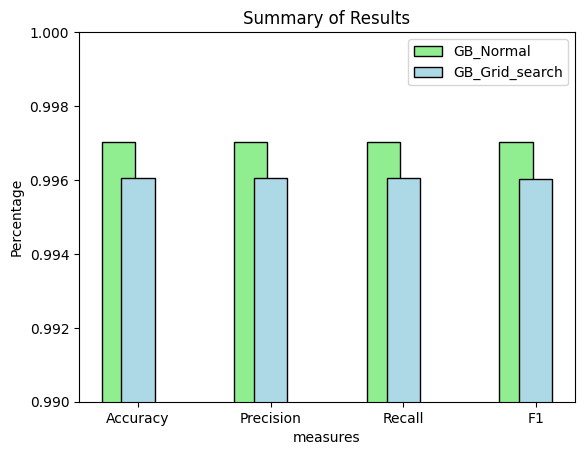

In [ ]:
measures = ['Accuracy','Precision','Recall','F1']

GB_Normal=[Accuracy_GB_Normal,Precision_GB_Normal,Recall_GB_Normal,F1_GB_Normal]
GB_Grid_search=[Accuracy_GB_Grid_search,Precision_GB_Grid_search,Recall_GB_Grid_search,F1_GB_Grid_search]

X_axis = np.arange(len(measures ))

plt.bar(X_axis + 0.1, GB_Normal, color ='lightgreen',width = 0.25,edgecolor = 'black',label = 'GB_Normal')
plt.bar(X_axis + 0.25, GB_Grid_search, color ='lightblue',width = 0.25,edgecolor = 'black',label = 'GB_Grid_search')
plt.xticks(X_axis+0.25, measures)

plt.ylim(0.99, 1)
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("measures")
plt.ylabel("Percentage")
plt.title("Summary of Results")
plt.show()

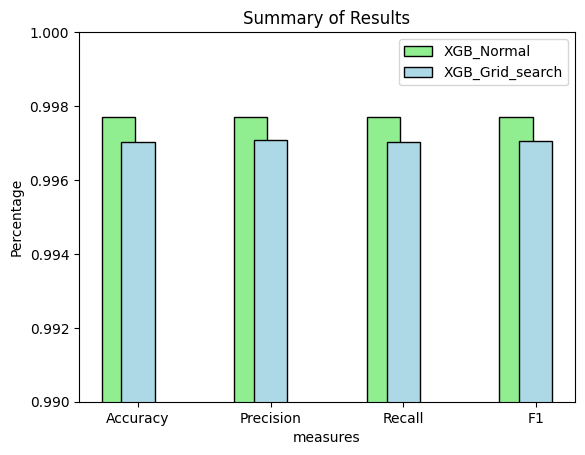

In [ ]:
measures = ['Accuracy','Precision','Recall','F1']

XGB_Normal=[Accuracy_XGB_Normal,Precision_XGB_Normal,Recall_XGB_Normal,F1_XGB_Normal]
XGB_Grid_search=[Accuracy_XGB_Grid_search,Precision_XGB_Grid_search,Recall_XGB_Grid_search,F1_XGB_Grid_search]

X_axis = np.arange(len(measures))

plt.bar(X_axis + 0.1, XGB_Normal, color ='lightgreen',width = 0.25,edgecolor = 'black',label = 'XGB_Normal')
plt.bar(X_axis + 0.25, XGB_Grid_search, color ='lightblue',width = 0.25,edgecolor = 'black',label = 'XGB_Grid_search')
plt.xticks(X_axis+0.25, measures)

plt.ylim(0.99, 1)
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("measures")
plt.ylabel("Percentage")
plt.title("Summary of Results")
plt.show()

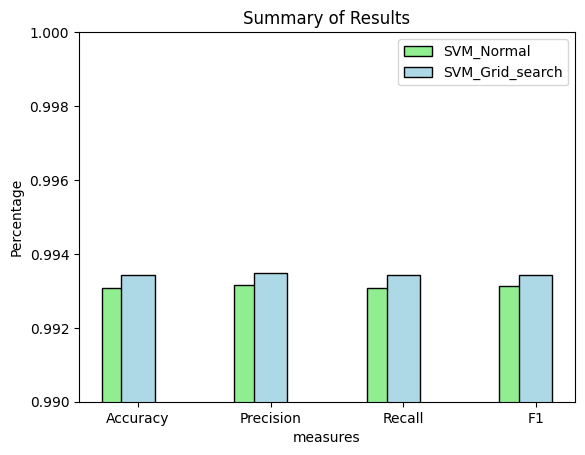

In [ ]:
measures = ['Accuracy','Precision','Recall','F1']

SVM_Normal=[Accuracy_SVM_Normal,Precision_SVM_Normal,Recall_SVM_Normal,F1_SVM_Normal]
SVM_Grid_search=[Accuracy_SVM_Grid_search,Precision_SVM_Grid_search,Recall_SVM_Grid_search,F1_SVM_Grid_search]

X_axis = np.arange(len(measures ))

plt.bar(X_axis + 0.1, SVM_Normal, color ='lightgreen',width = 0.25,edgecolor = 'black',label = 'SVM_Normal')
plt.bar(X_axis + 0.25, SVM_Grid_search, color ='lightblue',width = 0.25,edgecolor = 'black',label = 'SVM_Grid_search')
plt.xticks(X_axis+0.25, measures)

plt.ylim(0.99, 1)
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("measures")
plt.ylabel("Percentage")
plt.title("Summary of Results")
plt.show()